# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
#list(df_new['Target'])

In [11]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [12]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [13]:
# create empty dictionary
target_dfs = {}

In [14]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [15]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [16]:
# find row with maximum amount of data points for each target
max_dfrows = {}

In [17]:
for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [18]:
#max_dfrows

In [19]:
frames = list(max_dfrows[target] for target in targets)

In [20]:
merged_df = pd.concat(frames, axis=0)

In [21]:
units = list(set(merged_df['Unit']))

In [22]:
units.remove('Percent')
units

['Metric Tons', 'USD', 'Constant USD']

In [23]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17


In [24]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
64,121,Population,Suicide mortality rate,3,3.4,3.4.2,Percent,Units,NaN,NaN,...,NaN,1.123,NaN,NaN,NaN,NaN,1.073,NaN,NaN,4
151,46,Environment (percent),Proportion of fish stocks within biologically ...,14,14.4,14.4.1,Percent,Units,NaN,50.27,...,57.47,NaN,61.28,NaN,58.11,NaN,NaN,NaN,NaN,14
65,123,Population,Death rate due to road traffic injuries,3,3.6,3.6.1,Percent,Units,NaN,NaN,...,NaN,1.8,NaN,NaN,1.74,NaN,NaN,NaN,NaN,4
113,8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,Percent,Units,NaN,NaN,...,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN,16


### clean-up data frames

In [25]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [26]:
final_t

Target,17.19,3.4,14.4,3.6,8.1,3.3,3.1,12.2,9.c,4.2,...,15.4,15.2,16.a,9.2,17.2,2.1,14.5,15.1,10.c,17.8
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,50.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,43.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,42.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.6,NaN,NaN,NaN,NaN
1992,NaN,NaN,45.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.5,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.2,NaN,NaN,NaN,NaN


In [27]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,17.19,3.4,14.4,3.6,8.1,3.3,3.1,12.2,9.c,4.2,...,15.4,15.2,16.a,9.2,17.2,2.1,14.5,15.1,10.c,17.8
0,2.08601e+08,NaN,NaN,NaN,1.01,15,NaN,NaN,93.04,64.64,...,48.41,NaN,NaN,15.94,0.000115308,11.4,NaN,42.7,9,34.8
1,2.47954e+08,NaN,52.83,NaN,0.2,16.1,NaN,9.78,84.22,58.89,...,45.95,NaN,NaN,15.74,0.000112242,13,NaN,41.28,NaN,23.18
2,NaN,1.073,NaN,NaN,1.45,14.2,21.6,NaN,95.64,NaN,...,49.03,NaN,35.5,16.11,0.000131555,10.8,11.92,43.23,7.5,43.75
3,NaN,NaN,NaN,NaN,0.86,17.2,NaN,8.1,56.9,NaN,...,40.72,NaN,NaN,14.81,7.8409e-05,15,NaN,34.16,NaN,10.71
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.6,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,43.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.49844e+08,NaN,NaN,NaN,1.35,14.4,NaN,NaN,95.81,66.59,...,48.99,11.01,NaN,16.03,0.000123946,11,NaN,43.19,8.2,40.49
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.78255e+08,NaN,NaN,NaN,2.61,16.4,NaN,9.8,82.64,59.07,...,45.24,NaN,NaN,15.84,0.00010033,13.7,NaN,40.73,NaN,20.54


### R-squared value of linear regression to detect connections

In [28]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)
print(mask_train)
targets_X_train = final_t_shuffled[targetx][:-6].reshape(-1, 1)
print(targets_X_train)
print(targets_X_train[mask_train])

In [29]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return mae, rae, rmse, r2

17.19 14.4
MAE: 3.99200
RMSE: 5.10644
R2: 0.000
--------------------------


17.19 8.1
MAE: 1.64764
RMSE: 2.00279
R2: 0.107
--------------------------




/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


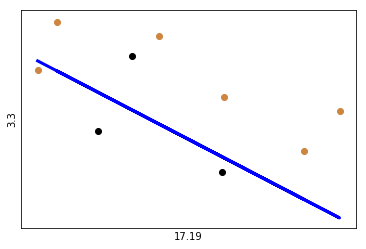

17.19 3.3
MAE: 0.88691
RMSE: 0.99980
R2: 0.000
--------------------------




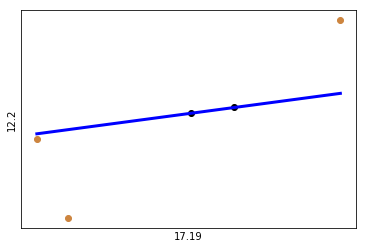

17.19 12.2
MAE: 0.19140
RMSE: 0.22785
R2: 0.336
--------------------------


17.19 9.c
MAE: 5.44807
RMSE: 6.11000
R2: 0.000
--------------------------


17.19 4.2
MAE: 3.54625
RMSE: 4.05282
R2: 0.000
--------------------------




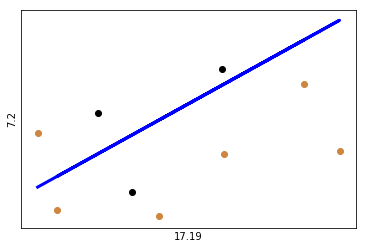

17.19 7.2
MAE: 0.68917
RMSE: 0.76037
R2: 0.000
--------------------------


17.19 6.2
MAE: 2.26728
RMSE: 2.51345
R2: 0.000
--------------------------


9.4 17.19
MAE: 105019642.90252
RMSE: 120089902.57139
R2: 0.142
--------------------------




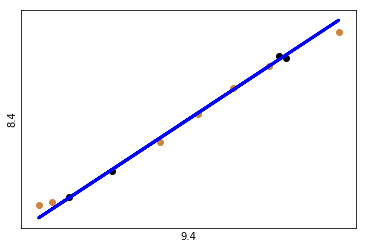

9.4 8.4
MAE: 0.06681
RMSE: 0.08564
R2: 0.987
--------------------------


9.4 6.1
MAE: 1.17910
RMSE: 1.49666
R2: 0.929
--------------------------


9.4 9.5
MAE: 1.34565
RMSE: 1.57175
R2: 0.971
--------------------------




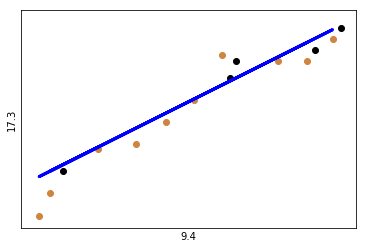

9.4 17.3
MAE: 0.02706
RMSE: 0.03463
R2: 0.892
--------------------------


9.4 8.2
MAE: 1.13069
RMSE: 1.38959
R2: 0.000
--------------------------


9.4 7.1
MAE: 2.30338
RMSE: 2.69208
R2: 0.000
--------------------------




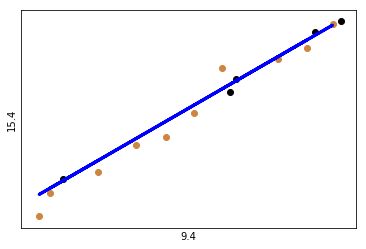

9.4 15.4
MAE: 0.52454
RMSE: 0.63126
R2: 0.963
--------------------------




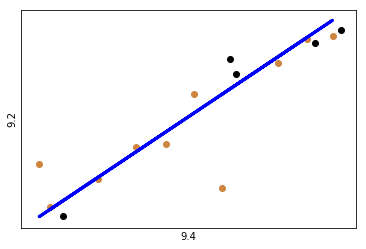

9.4 9.2
MAE: 0.13818
RMSE: 0.23157
R2: 0.655
--------------------------




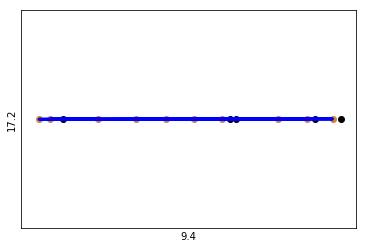

9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.808
--------------------------




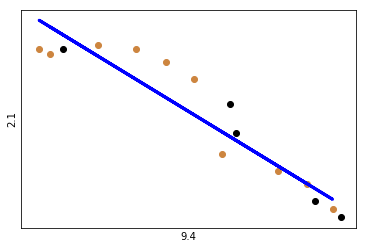

9.4 2.1
MAE: 0.49011
RMSE: 0.57245
R2: 0.851
--------------------------




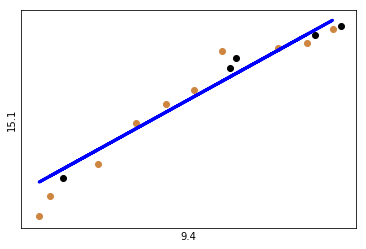

9.4 15.1
MAE: 0.83474
RMSE: 1.02288
R2: 0.927
--------------------------




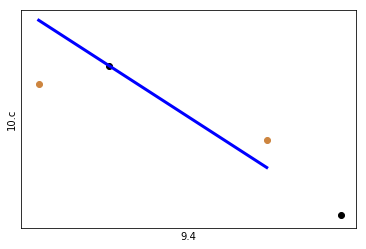

9.4 10.c
MAE: 0.24333
RMSE: 0.26261
R2: 0.000
--------------------------


9.4 17.8
MAE: 1.68694
RMSE: 1.92873
R2: 0.962
--------------------------


3.4 8.1
MAE: 2.01690
RMSE: 2.07933
R2: 0.000
--------------------------




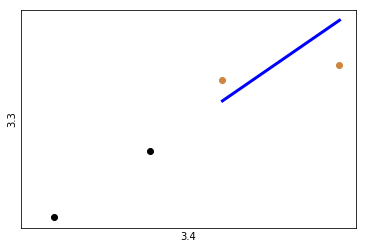

3.4 3.3
MAE: 0.64300
RMSE: 0.68323
R2: 0.000
--------------------------


3.4 3.1
MAE: 2.74000
RMSE: 2.86007
R2: 0.000
--------------------------


12.2 9.c
MAE: 7.06387
RMSE: 10.48631
R2: 0.243
--------------------------




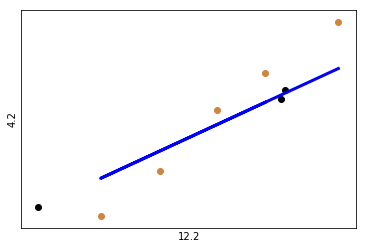

12.2 4.2
MAE: 0.60135
RMSE: 0.64496
R2: 0.787
--------------------------




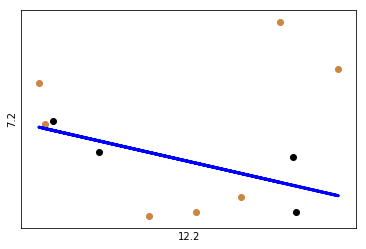

12.2 7.2
MAE: 0.28404
RMSE: 0.35873
R2: 0.000
--------------------------




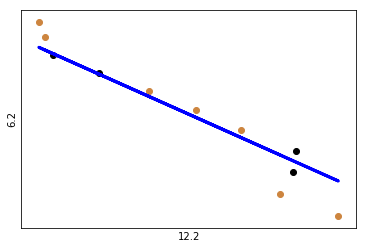

12.2 6.2
MAE: 0.60433
RMSE: 0.73117
R2: 0.884
--------------------------




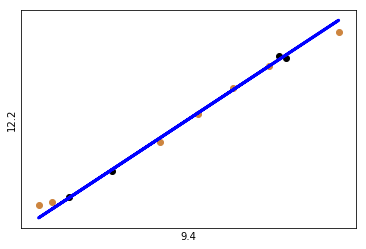

9.4 12.2
MAE: 0.06681
RMSE: 0.08564
R2: 0.987
--------------------------


14.4 8.1
MAE: 2.02838
RMSE: 2.61368
R2: 0.000
--------------------------




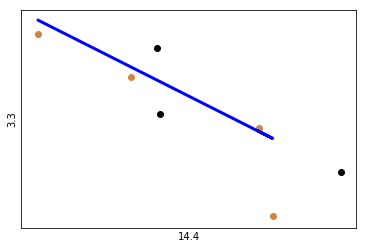

14.4 3.3
MAE: 0.35667
RMSE: 0.54407
R2: 0.658
--------------------------


12.2 14.4
MAE: 3.79215
RMSE: 4.20105
R2: 0.010
--------------------------




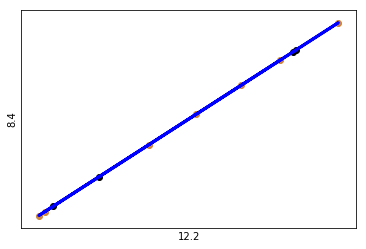

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
--------------------------


12.2 6.1
MAE: 1.17857
RMSE: 1.50738
R2: 0.918
--------------------------


12.2 9.5
MAE: 1.91397
RMSE: 2.24669
R2: 0.914
--------------------------




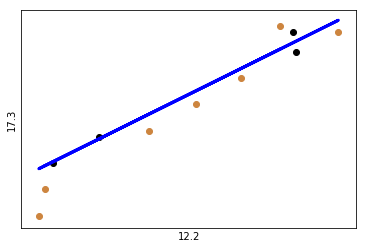

12.2 17.3
MAE: 0.03183
RMSE: 0.03653
R2: 0.875
--------------------------


12.2 8.2
MAE: 1.36762
RMSE: 1.64771
R2: 0.000
--------------------------




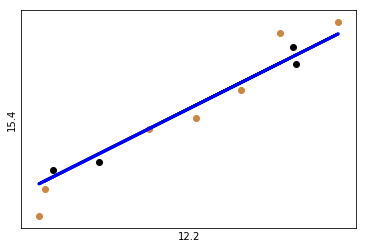

12.2 15.4
MAE: 0.61334
RMSE: 0.77030
R2: 0.927
--------------------------




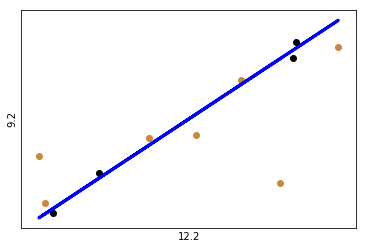

12.2 9.2
MAE: 0.21964
RMSE: 0.32569
R2: 0.000
--------------------------




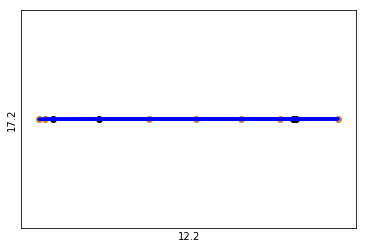

12.2 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.723
--------------------------




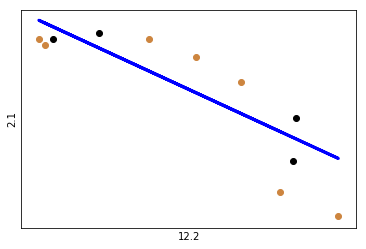

12.2 2.1
MAE: 0.60324
RMSE: 0.65099
R2: 0.678
--------------------------




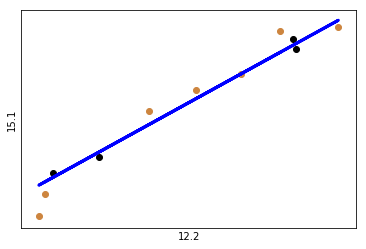

12.2 15.1
MAE: 0.70649
RMSE: 0.86158
R2: 0.944
--------------------------


12.2 17.8
MAE: 2.72070
RMSE: 3.12342
R2: 0.837
--------------------------


3.6 8.1
MAE: 1.20000
RMSE: 1.35765
R2: 0.000
--------------------------


3.6 3.3
MAE: 1.10000
RMSE: 1.22984
R2: 0.000
--------------------------


8.1 3.3
MAE: 1.06360
RMSE: 1.25032
R2: 0.000
--------------------------


8.1 3.1
MAE: 7.15657
RMSE: 7.41156
R2: 0.000
--------------------------


12.2 8.1
MAE: 1.76675
RMSE: 2.16399
R2: 0.000
--------------------------


3.3 3.1
MAE: 3.27308
RMSE: 4.00259
R2: 0.000
--------------------------




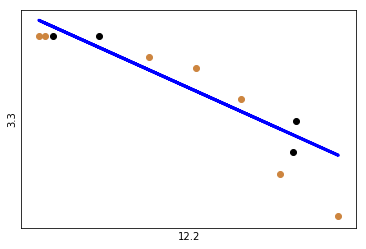

12.2 3.3
MAE: 0.24558
RMSE: 0.29739
R2: 0.768
--------------------------




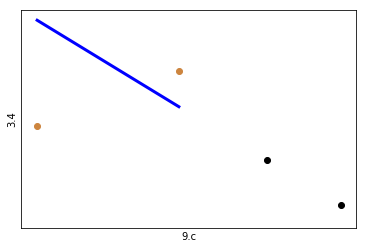

9.c 3.4
MAE: 0.07829
RMSE: 0.08722
R2: 0.000
--------------------------


9.c 14.4
MAE: 3.39592
RMSE: 4.67656
R2: 0.000
--------------------------




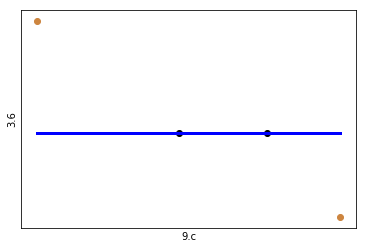

9.c 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


9.c 8.1
MAE: 1.40048
RMSE: 1.84230
R2: 0.000
--------------------------




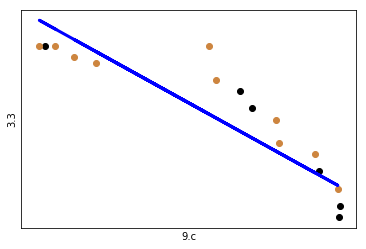

9.c 3.3
MAE: 0.42047
RMSE: 0.52323
R2: 0.645
--------------------------


9.c 3.1
MAE: 5.51731
RMSE: 5.53425
R2: 0.000
--------------------------


9.c 4.2
MAE: 5.26704
RMSE: 7.11050
R2: 0.000
--------------------------




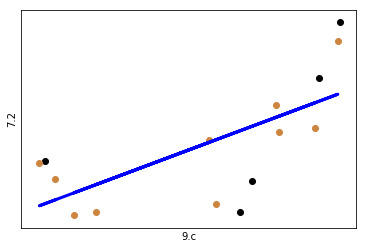

9.c 7.2
MAE: 0.21468
RMSE: 0.25442
R2: 0.567
--------------------------


9.c 6.2
MAE: 1.28711
RMSE: 1.77836
R2: 0.557
--------------------------


9.4 9.c
MAE: 5.58815
RMSE: 8.88384
R2: 0.612
--------------------------


4.2 14.4
MAE: 4.61287
RMSE: 5.47853
R2: 0.000
--------------------------


4.2 8.1
MAE: 1.30865
RMSE: 1.88077
R2: 0.005
--------------------------




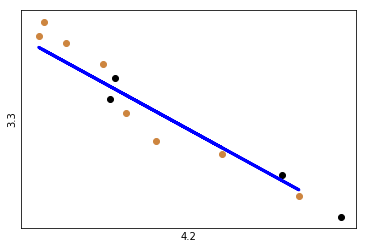

4.2 3.3
MAE: 0.24439
RMSE: 0.27071
R2: 0.901
--------------------------




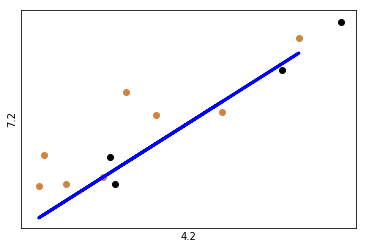

4.2 7.2
MAE: 0.25578
RMSE: 0.32476
R2: 0.431
--------------------------




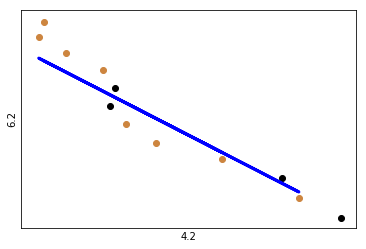

4.2 6.2
MAE: 0.74105
RMSE: 0.82850
R2: 0.866
--------------------------


9.4 4.2
MAE: 2.75987
RMSE: 3.39552
R2: 0.000
--------------------------


7.2 14.4
MAE: 7.47174
RMSE: 8.74295
R2: 0.000
--------------------------




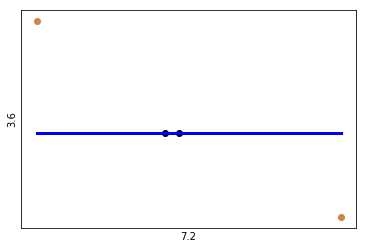

7.2 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


7.2 8.1
MAE: 1.30269
RMSE: 1.75721
R2: 0.020
--------------------------




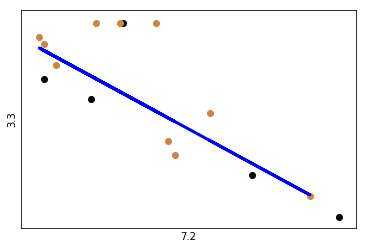

7.2 3.3
MAE: 0.46545
RMSE: 0.61569
R2: 0.508
--------------------------


7.2 6.2
MAE: 1.50773
RMSE: 2.19381
R2: 0.326
--------------------------




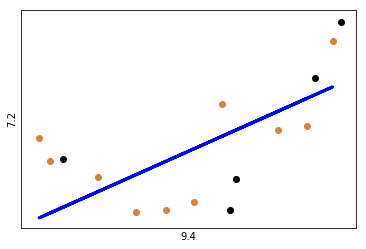

9.4 7.2
MAE: 0.31189
RMSE: 0.34041
R2: 0.226
--------------------------




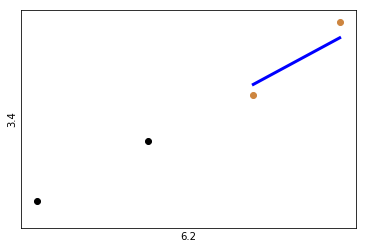

6.2 3.4
MAE: 0.01118
RMSE: 0.01140
R2: 0.860
--------------------------


6.2 14.4
MAE: 1.68107
RMSE: 2.28348
R2: 0.743
--------------------------




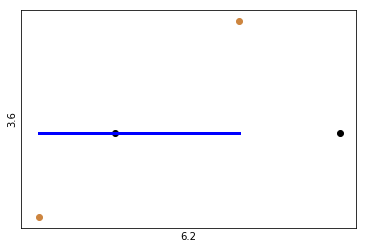

6.2 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


6.2 8.1
MAE: 1.38615
RMSE: 1.82639
R2: 0.000
--------------------------




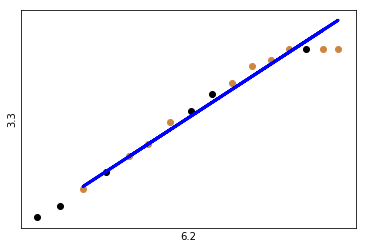

6.2 3.3
MAE: 0.14945
RMSE: 0.21467
R2: 0.940
--------------------------


6.2 3.1
MAE: 2.87355
RMSE: 3.23721
R2: 0.000
--------------------------




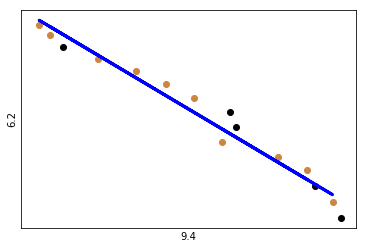

9.4 6.2
MAE: 0.39258
RMSE: 0.42238
R2: 0.975
--------------------------


9.4 14.4
MAE: 1.86947
RMSE: 2.07437
R2: 0.788
--------------------------




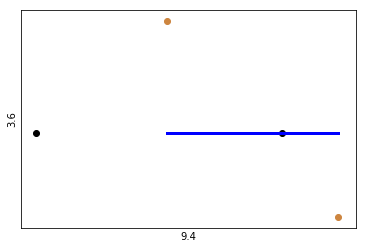

9.4 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


9.4 8.1
MAE: 1.40202
RMSE: 1.83722
R2: 0.000
--------------------------




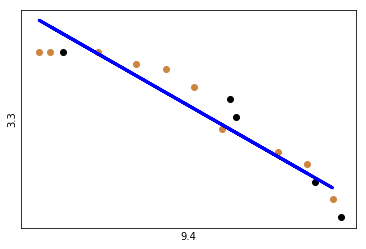

9.4 3.3
MAE: 0.24496
RMSE: 0.29552
R2: 0.887
--------------------------




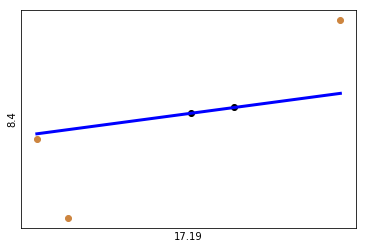

17.19 8.4
MAE: 0.19140
RMSE: 0.22785
R2: 0.336
--------------------------


17.19 6.1
MAE: 1.94487
RMSE: 2.55530
R2: 0.000
--------------------------


17.19 9.5
MAE: 6.14814
RMSE: 6.86805
R2: 0.000
--------------------------




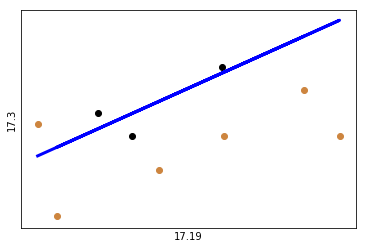

17.19 17.3
MAE: 0.05832
RMSE: 0.06229
R2: 0.000
--------------------------


17.19 8.2
MAE: 1.65855
RMSE: 1.85503
R2: 0.000
--------------------------


17.19 15.4
MAE: 1.62231
RMSE: 1.90138
R2: 0.000
--------------------------




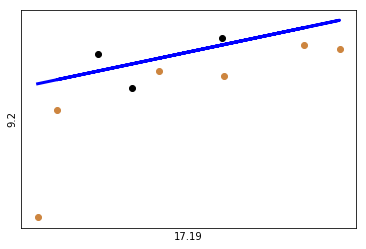

17.19 9.2
MAE: 0.24606
RMSE: 0.34377
R2: 0.000
--------------------------




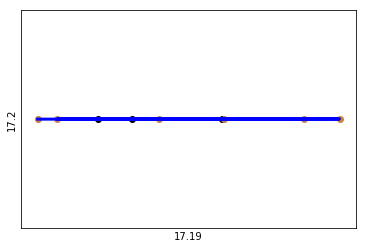

17.19 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.000
--------------------------


17.19 2.1
MAE: 1.08570
RMSE: 1.28404
R2: 0.000
--------------------------


17.19 15.1
MAE: 1.21198
RMSE: 1.41591
R2: 0.000
--------------------------


17.19 10.c
MAE: 1.19140
RMSE: 1.22012
R2: 0.000
--------------------------


17.19 17.8
MAE: 9.04620
RMSE: 10.07467
R2: 0.000
--------------------------




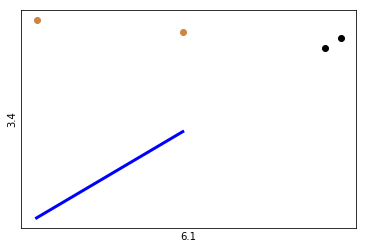

6.1 3.4
MAE: 0.81782
RMSE: 0.86051
R2: 0.000
--------------------------




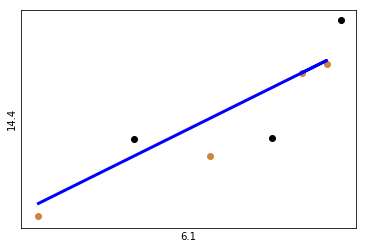

6.1 14.4
MAE: 0.99364
RMSE: 1.44285
R2: 0.897
--------------------------




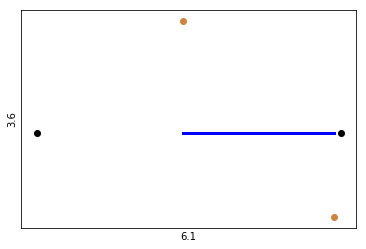

6.1 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


6.1 8.1
MAE: 1.37556
RMSE: 1.82867
R2: 0.000
--------------------------




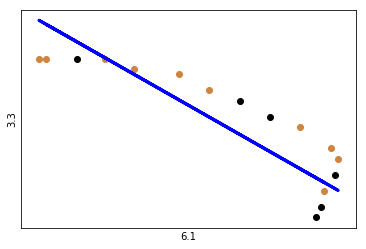

6.1 3.3
MAE: 0.47312
RMSE: 0.54379
R2: 0.616
--------------------------


6.1 3.1
MAE: 51.80946
RMSE: 54.48986
R2: 0.000
--------------------------


6.1 9.c
MAE: 6.64707
RMSE: 9.82096
R2: 0.525
--------------------------


6.1 4.2
MAE: 4.35904
RMSE: 5.01469
R2: 0.000
--------------------------




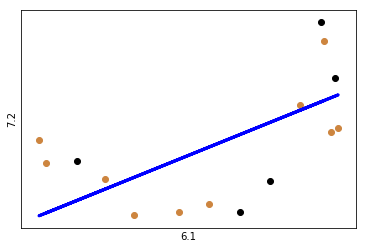

6.1 7.2
MAE: 0.31083
RMSE: 0.34809
R2: 0.190
--------------------------




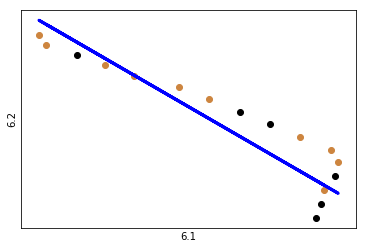

6.1 6.2
MAE: 0.99555
RMSE: 1.19349
R2: 0.800
--------------------------


8.4 6.1
MAE: 1.17857
RMSE: 1.50738
R2: 0.918
--------------------------


8.4 9.5
MAE: 1.91397
RMSE: 2.24669
R2: 0.914
--------------------------




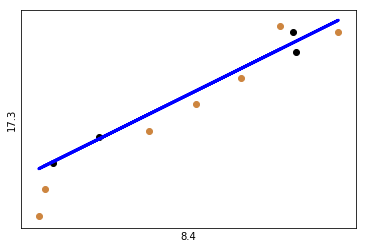

8.4 17.3
MAE: 0.03183
RMSE: 0.03653
R2: 0.875
--------------------------


8.4 8.2
MAE: 1.36762
RMSE: 1.64771
R2: 0.000
--------------------------




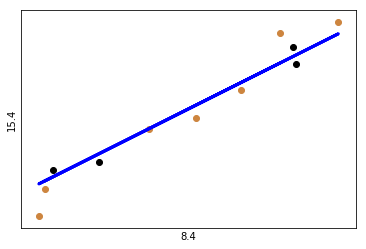

8.4 15.4
MAE: 0.61334
RMSE: 0.77030
R2: 0.927
--------------------------




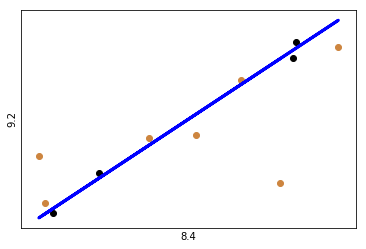

8.4 9.2
MAE: 0.21964
RMSE: 0.32569
R2: 0.000
--------------------------




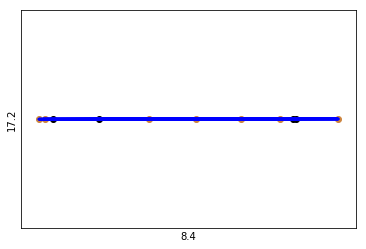

8.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.723
--------------------------




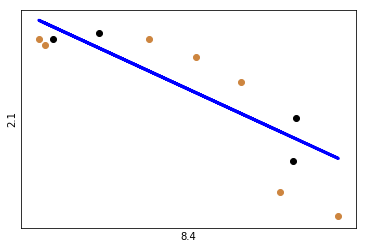

8.4 2.1
MAE: 0.60324
RMSE: 0.65099
R2: 0.678
--------------------------




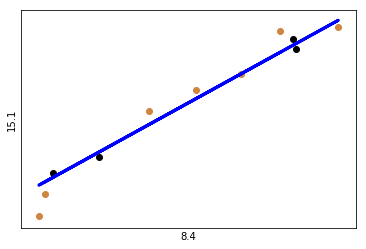

8.4 15.1
MAE: 0.70649
RMSE: 0.86158
R2: 0.944
--------------------------


8.4 17.8
MAE: 2.72070
RMSE: 3.12342
R2: 0.837
--------------------------


9.5 14.4
MAE: 1.65753
RMSE: 1.95096
R2: 0.812
--------------------------




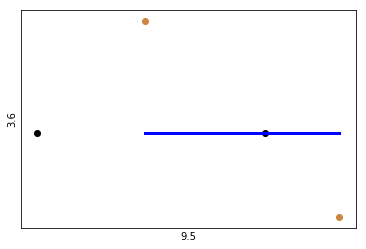

9.5 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


9.5 8.1
MAE: 1.38216
RMSE: 1.82069
R2: 0.000
--------------------------




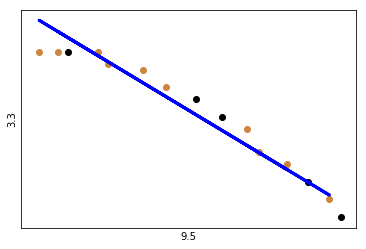

9.5 3.3
MAE: 0.18292
RMSE: 0.24282
R2: 0.923
--------------------------


9.5 9.c
MAE: 5.45856
RMSE: 8.15790
R2: 0.673
--------------------------


9.5 4.2
MAE: 1.95946
RMSE: 2.21099
R2: 0.398
--------------------------




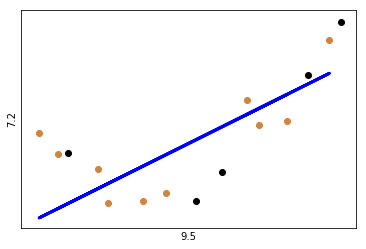

9.5 7.2
MAE: 0.27317
RMSE: 0.31847
R2: 0.322
--------------------------




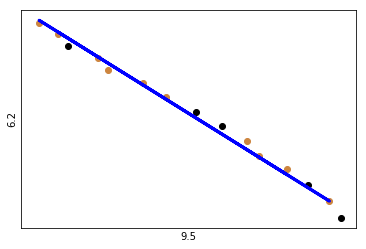

9.5 6.2
MAE: 0.14868
RMSE: 0.19467
R2: 0.995
--------------------------


9.5 6.1
MAE: 1.35478
RMSE: 1.53748
R2: 0.925
--------------------------




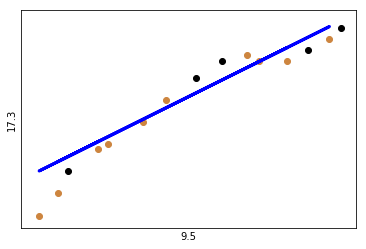

9.5 17.3
MAE: 0.02546
RMSE: 0.03462
R2: 0.892
--------------------------


9.5 8.2
MAE: 1.12508
RMSE: 1.38516
R2: 0.000
--------------------------




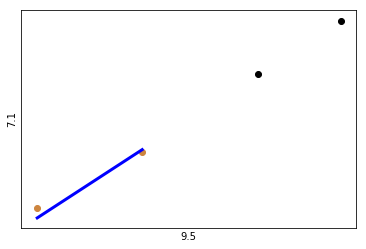

9.5 7.1
MAE: 0.33562
RMSE: 0.39865
R2: 0.926
--------------------------




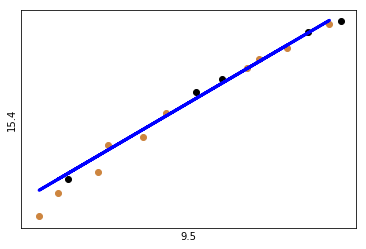

9.5 15.4
MAE: 0.41897
RMSE: 0.57348
R2: 0.969
--------------------------




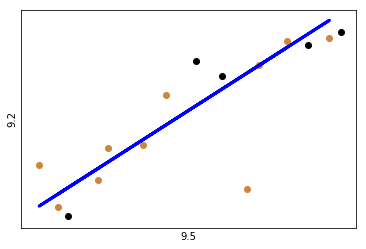

9.5 9.2
MAE: 0.16896
RMSE: 0.27205
R2: 0.523
--------------------------


17.2 9.5
MAE: 3.82408
RMSE: 5.37161
R2: 0.667
--------------------------




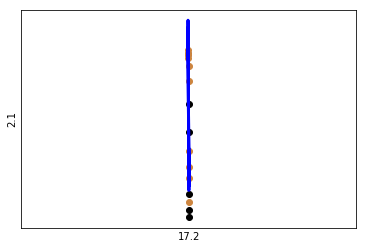

17.2 2.1
MAE: 0.80698
RMSE: 1.10188
R2: 0.448
--------------------------


17.2 14.5
MAE: 7.02134
RMSE: 8.89791
R2: 0.000
--------------------------


17.2 15.1
MAE: 1.29307
RMSE: 1.69345
R2: 0.808
--------------------------




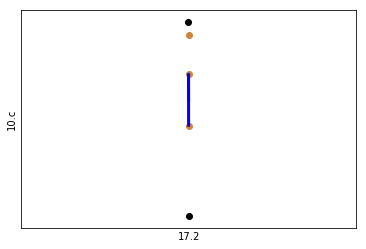

17.2 10.c
MAE: 0.16949
RMSE: 0.21057
R2: 0.461
--------------------------


17.2 17.8
MAE: 5.16576
RMSE: 7.03013
R2: 0.498
--------------------------




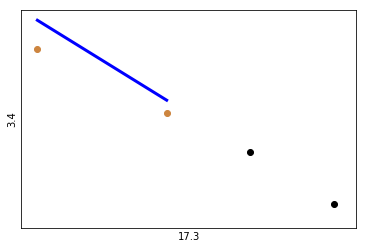

17.3 3.4
MAE: 0.02014
RMSE: 0.02172
R2: 0.493
--------------------------


17.3 14.4
MAE: 1.38017
RMSE: 1.97144
R2: 0.808
--------------------------




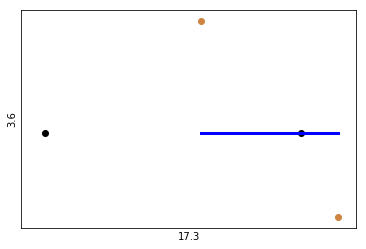

17.3 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


17.3 8.1
MAE: 1.40811
RMSE: 1.85619
R2: 0.000
--------------------------




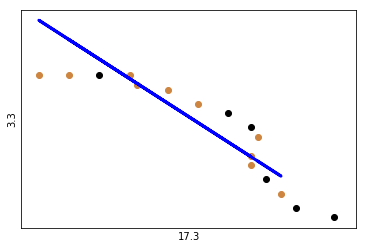

17.3 3.3
MAE: 0.37881
RMSE: 0.51063
R2: 0.662
--------------------------


17.3 3.1
MAE: 1.53182
RMSE: 1.56734
R2: 0.650
--------------------------


17.3 9.c
MAE: 6.85566
RMSE: 10.70594
R2: 0.436
--------------------------


17.3 4.2
MAE: 4.49318
RMSE: 5.83232
R2: 0.000
--------------------------




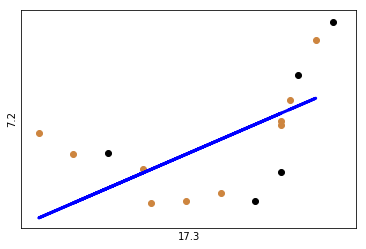

17.3 7.2
MAE: 0.28618
RMSE: 0.35168
R2: 0.173
--------------------------




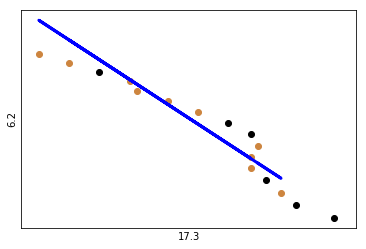

17.3 6.2
MAE: 0.73458
RMSE: 0.94524
R2: 0.875
--------------------------


17.3 6.1
MAE: 1.27695
RMSE: 1.72666
R2: 0.905
--------------------------




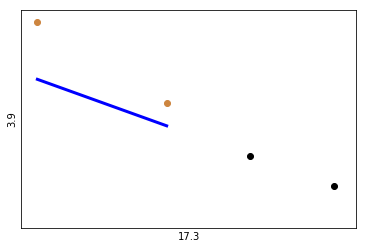

17.3 3.9
MAE: 0.01745
RMSE: 0.01898
R2: 0.000
--------------------------


17.3 8.2
MAE: 1.14422
RMSE: 1.40336
R2: 0.000
--------------------------


17.3 7.1
MAE: 3.65000
RMSE: 4.45444
R2: 0.000
--------------------------




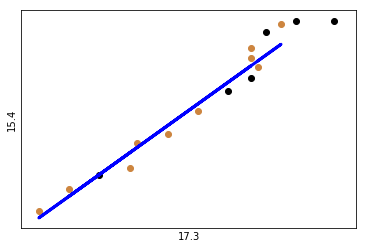

17.3 15.4
MAE: 0.54940
RMSE: 0.61480
R2: 0.965
--------------------------


17.3 16.a
MAE: 6.24091
RMSE: 7.32813
R2: 0.000
--------------------------




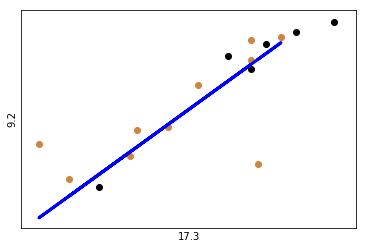

17.3 9.2
MAE: 0.21471
RMSE: 0.33567
R2: 0.275
--------------------------




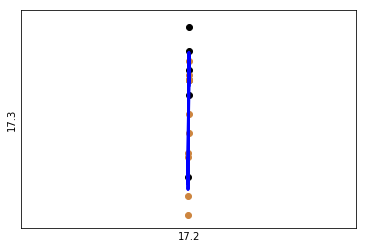

17.2 17.3
MAE: 0.04055
RMSE: 0.05407
R2: 0.736
--------------------------




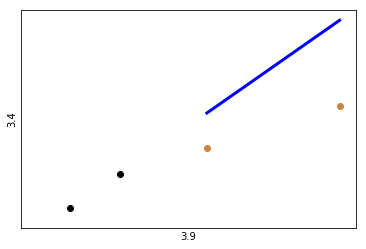

3.9 3.4
MAE: 0.08727
RMSE: 0.09471
R2: 0.000
--------------------------


3.9 8.1
MAE: 4.40808
RMSE: 4.66091
R2: 0.000
--------------------------


3.9 3.3
MAE: 2.50000
RMSE: 2.96816
R2: 0.000
--------------------------


3.9 3.1
MAE: 2.49615
RMSE: 2.85633
R2: 0.000
--------------------------


3.9 9.c
MAE: 17.95500
RMSE: 19.50308
R2: 0.000
--------------------------


3.9 6.2
MAE: 6.46154
RMSE: 7.33178
R2: 0.000
--------------------------


3.9 6.1
MAE: 13.39538
RMSE: 14.13300
R2: 0.000
--------------------------


3.9 8.2
MAE: 8.73192
RMSE: 9.29492
R2: 0.000
--------------------------




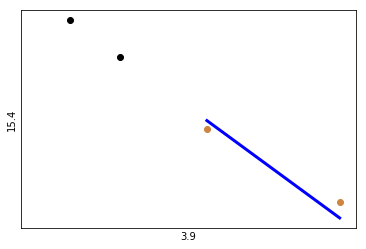

3.9 15.4
MAE: 0.68115
RMSE: 0.71592
R2: 0.880
--------------------------


3.9 16.a
MAE: 2.75000
RMSE: 3.61732
R2: 0.618
--------------------------




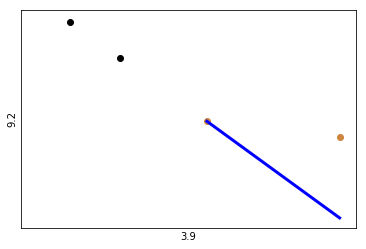

3.9 9.2
MAE: 0.33962
RMSE: 0.47975
R2: 0.000
--------------------------




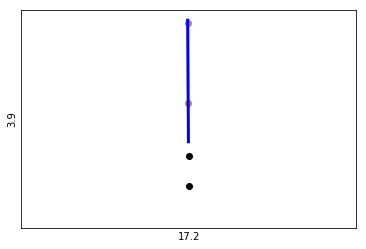

17.2 3.9
MAE: 0.00894
RMSE: 0.01181
R2: 0.545
--------------------------




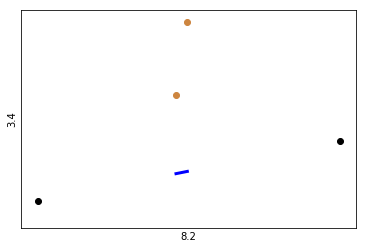

8.2 3.4
MAE: 0.09465
RMSE: 0.09916
R2: 0.000
--------------------------


8.2 14.4
MAE: 4.33695
RMSE: 5.00526
R2: 0.000
--------------------------




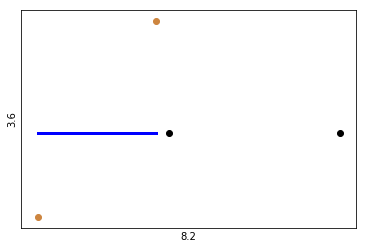

8.2 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------




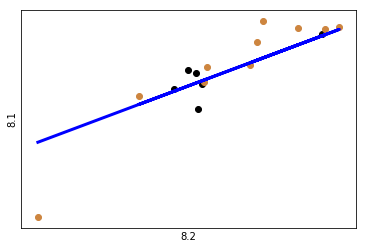

8.2 8.1
MAE: 0.56885
RMSE: 0.89088
R2: 0.748
--------------------------


8.2 3.3
MAE: 1.09502
RMSE: 1.20223
R2: 0.000
--------------------------


8.2 3.1
MAE: 8.41875
RMSE: 8.80925
R2: 0.000
--------------------------


8.2 9.c
MAE: 14.06426
RMSE: 16.98272
R2: 0.000
--------------------------


8.2 4.2
MAE: 3.58097
RMSE: 4.59822
R2: 0.000
--------------------------




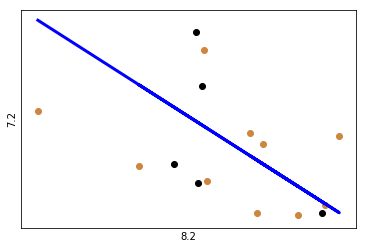

8.2 7.2
MAE: 0.39549
RMSE: 0.45711
R2: 0.000
--------------------------


8.2 6.2
MAE: 3.07468
RMSE: 3.51708
R2: 0.000
--------------------------


8.2 6.1
MAE: 5.62882
RMSE: 6.38875
R2: 0.000
--------------------------


8.2 7.1
MAE: 7.15013
RMSE: 7.28855
R2: 0.000
--------------------------


8.2 15.4
MAE: 3.26764
RMSE: 3.96317
R2: 0.000
--------------------------


8.2 16.a
MAE: 8.52000
RMSE: 11.05680
R2: 0.000
--------------------------




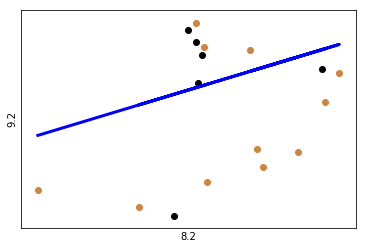

8.2 9.2
MAE: 0.46728
RMSE: 0.50833
R2: 0.000
--------------------------


17.2 8.2
MAE: 1.04929
RMSE: 1.34034
R2: 0.000
--------------------------


7.1 8.1
MAE: 3.02824
RMSE: 3.05874
R2: 0.000
--------------------------




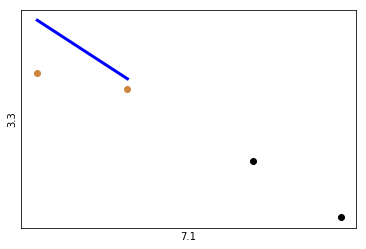

7.1 3.3
MAE: 0.61127
RMSE: 0.74129
R2: 0.000
--------------------------


7.1 9.c
MAE: 11.58032
RMSE: 11.62565
R2: 0.000
--------------------------


7.1 7.2
MAE: 1.28113
RMSE: 1.45723
R2: 0.000
--------------------------




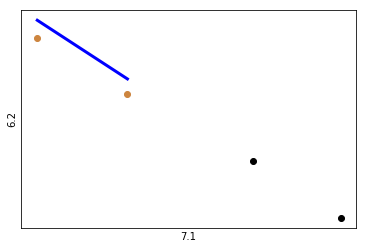

7.1 6.2
MAE: 0.81465
RMSE: 0.81858
R2: 0.656
--------------------------


7.1 6.1
MAE: 12.11169
RMSE: 12.68759
R2: 0.000
--------------------------


7.1 15.4
MAE: 2.20542
RMSE: 2.43400
R2: 0.000
--------------------------




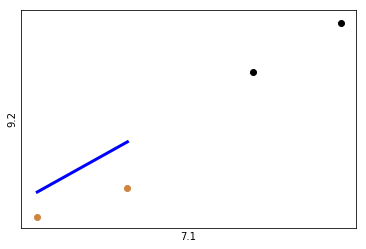

7.1 9.2
MAE: 0.16275
RMSE: 0.16993
R2: 0.000
--------------------------


17.2 7.1
MAE: 18.02299
RMSE: 25.16733
R2: 0.000
--------------------------




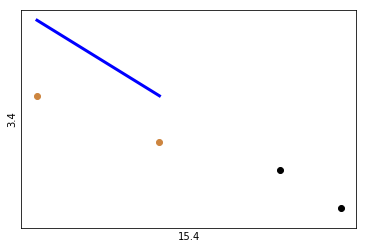

15.4 3.4
MAE: 0.08187
RMSE: 0.08430
R2: 0.000
--------------------------


15.4 14.4
MAE: 1.46675
RMSE: 1.77403
R2: 0.845
--------------------------




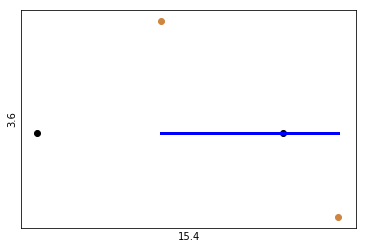

15.4 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


15.4 8.1
MAE: 1.39574
RMSE: 1.83842
R2: 0.000
--------------------------




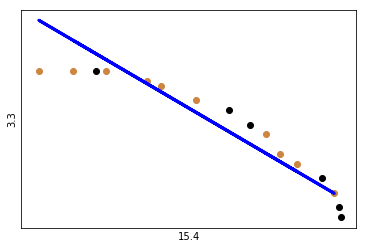

15.4 3.3
MAE: 0.30644
RMSE: 0.42769
R2: 0.763
--------------------------


15.4 3.1
MAE: 2.17206
RMSE: 2.20622
R2: 0.307
--------------------------


15.4 9.c
MAE: 5.31337
RMSE: 9.59977
R2: 0.547
--------------------------


15.4 4.2
MAE: 2.75104
RMSE: 3.45398
R2: 0.000
--------------------------




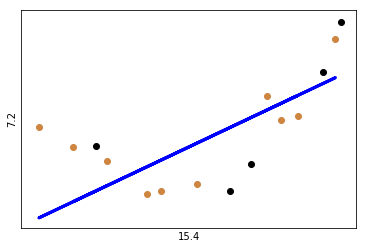

15.4 7.2
MAE: 0.30149
RMSE: 0.35245
R2: 0.170
--------------------------




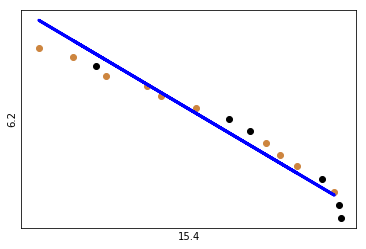

15.4 6.2
MAE: 0.59126
RMSE: 0.73329
R2: 0.925
--------------------------


15.4 6.1
MAE: 1.08977
RMSE: 1.38485
R2: 0.939
--------------------------


15.4 16.a
MAE: 2.46601
RMSE: 3.65195
R2: 0.807
--------------------------




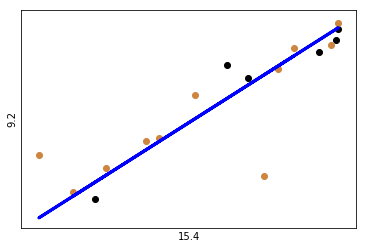

15.4 9.2
MAE: 0.16794
RMSE: 0.28407
R2: 0.573
--------------------------


17.2 15.4
MAE: 1.27237
RMSE: 1.75995
R2: 0.739
--------------------------




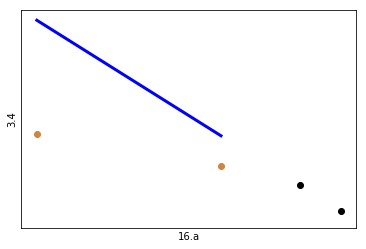

16.a 3.4
MAE: 0.14015
RMSE: 0.16238
R2: 0.000
--------------------------


16.a 8.1
MAE: 5.85712
RMSE: 6.47163
R2: 0.000
--------------------------


16.a 3.3
MAE: 3.87500
RMSE: 4.76616
R2: 0.000
--------------------------


16.a 3.1
MAE: 5.66923
RMSE: 6.99644
R2: 0.000
--------------------------


16.a 9.c
MAE: 25.00500
RMSE: 29.61331
R2: 0.000
--------------------------


16.a 6.2
MAE: 10.27981
RMSE: 12.28551
R2: 0.000
--------------------------


16.a 6.1
MAE: 14.17808
RMSE: 15.09299
R2: 0.000
--------------------------




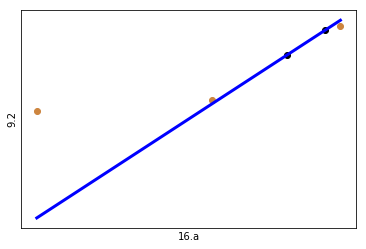

16.a 9.2
MAE: 0.45974
RMSE: 0.73293
R2: 0.000
--------------------------


17.2 16.a
MAE: 3.46218
RMSE: 3.68441
R2: 0.804
--------------------------




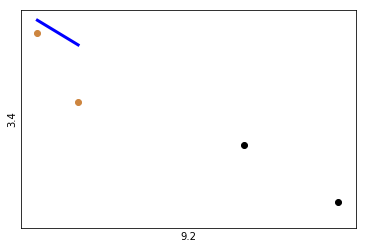

9.2 3.4
MAE: 0.03067
RMSE: 0.03643
R2: 0.000
--------------------------


9.2 14.4
MAE: 4.12004
RMSE: 5.00602
R2: 0.000
--------------------------




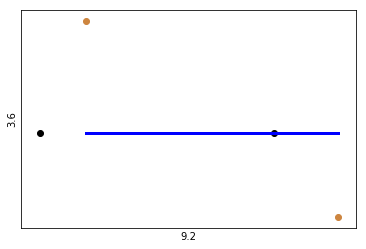

9.2 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


9.2 8.1
MAE: 1.38347
RMSE: 1.78038
R2: 0.000
--------------------------




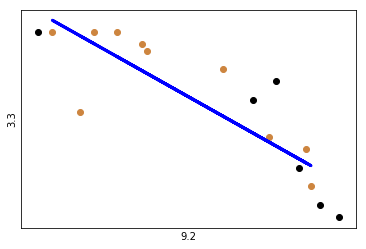

9.2 3.3
MAE: 0.42254
RMSE: 0.53329
R2: 0.631
--------------------------


9.2 3.1
MAE: 2.00000
RMSE: 2.19317
R2: 0.315
--------------------------


9.2 9.c
MAE: 6.73990
RMSE: 9.88594
R2: 0.519
--------------------------


9.2 4.2
MAE: 9.47298
RMSE: 12.66298
R2: 0.000
--------------------------




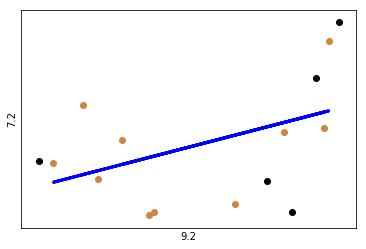

9.2 7.2
MAE: 0.29847
RMSE: 0.35309
R2: 0.167
--------------------------


9.2 6.2
MAE: 1.14216
RMSE: 1.65572
R2: 0.616
--------------------------


9.2 6.1
MAE: 2.65253
RMSE: 3.71092
R2: 0.561
--------------------------




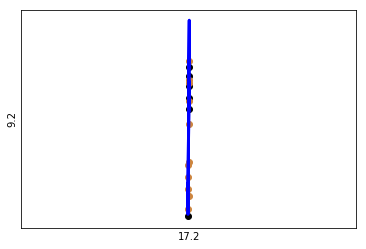

17.2 9.2
MAE: 0.22863
RMSE: 0.34802
R2: 0.360
--------------------------




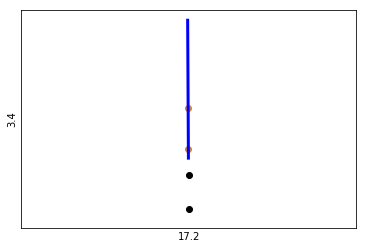

17.2 3.4
MAE: 0.07121
RMSE: 0.09159
R2: 0.000
--------------------------


17.2 14.4
MAE: 1.69105
RMSE: 2.41683
R2: 0.712
--------------------------




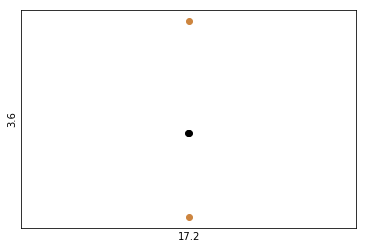

17.2 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


17.2 8.1
MAE: 1.35248
RMSE: 1.80235
R2: 0.000
--------------------------




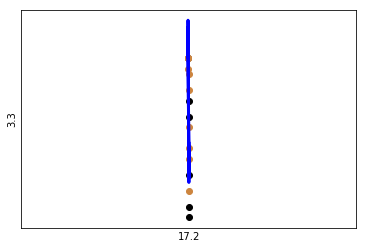

17.2 3.3
MAE: 0.56807
RMSE: 0.73154
R2: 0.305
--------------------------


17.2 3.1
MAE: 3.45251
RMSE: 3.52608
R2: 0.000
--------------------------


17.2 9.c
MAE: 7.36488
RMSE: 11.33093
R2: 0.368
--------------------------


17.2 4.2
MAE: 3.13579
RMSE: 3.54763
R2: 0.000
--------------------------




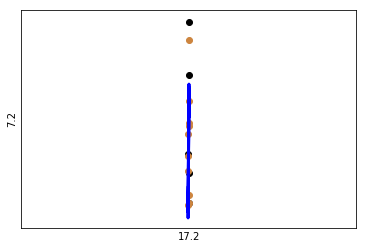

17.2 7.2
MAE: 0.38242
RMSE: 0.44711
R2: 0.000
--------------------------


17.2 6.2
MAE: 1.23444
RMSE: 1.69977
R2: 0.595
--------------------------


17.2 6.1
MAE: 1.73811
RMSE: 2.14256
R2: 0.854
--------------------------




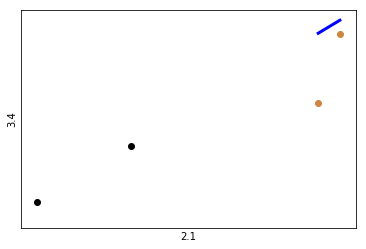

2.1 3.4
MAE: 0.03727
RMSE: 0.04473
R2: 0.000
--------------------------


2.1 14.4
MAE: 2.63428
RMSE: 3.72585
R2: 0.533
--------------------------




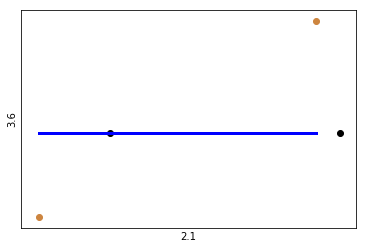

2.1 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


2.1 8.1
MAE: 1.35558
RMSE: 1.80341
R2: 0.000
--------------------------




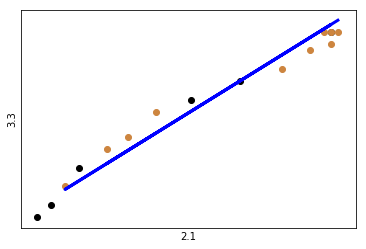

2.1 3.3
MAE: 0.19530
RMSE: 0.21632
R2: 0.939
--------------------------


2.1 3.1
MAE: 2.30385
RMSE: 2.35830
R2: 0.208
--------------------------


2.1 9.c
MAE: 4.95872
RMSE: 6.60856
R2: 0.785
--------------------------


2.1 4.2
MAE: 1.93854
RMSE: 2.08818
R2: 0.463
--------------------------




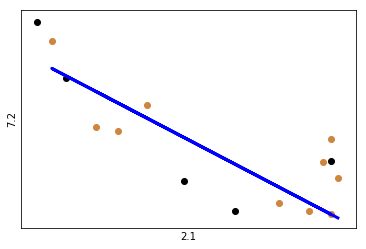

2.1 7.2
MAE: 0.22035
RMSE: 0.26973
R2: 0.514
--------------------------




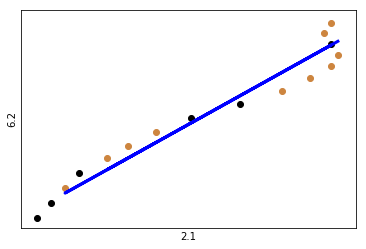

2.1 6.2
MAE: 0.77483
RMSE: 0.81864
R2: 0.906
--------------------------


2.1 6.1
MAE: 2.09126
RMSE: 2.51703
R2: 0.798
--------------------------


2.1 9.5
MAE: 2.06391
RMSE: 2.57817
R2: 0.923
--------------------------




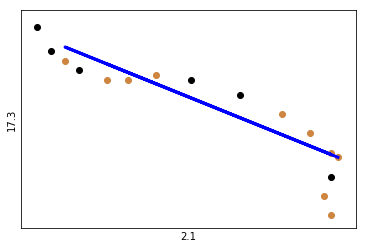

2.1 17.3
MAE: 0.03866
RMSE: 0.05422
R2: 0.734
--------------------------




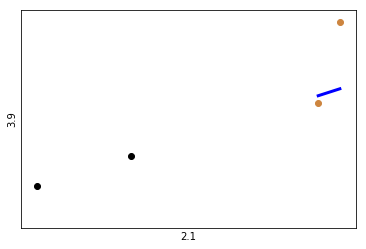

2.1 3.9
MAE: 0.01600
RMSE: 0.02062
R2: 0.000
--------------------------


2.1 8.2
MAE: 1.09223
RMSE: 1.36659
R2: 0.001
--------------------------


2.1 7.1
MAE: 1.52000
RMSE: 1.86620
R2: 0.000
--------------------------




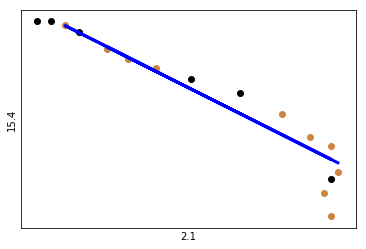

2.1 15.4
MAE: 0.82741
RMSE: 1.22591
R2: 0.859
--------------------------


2.1 16.a
MAE: 5.55000
RMSE: 7.70876
R2: 0.000
--------------------------




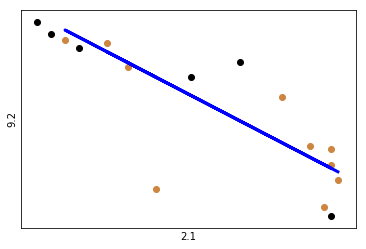

2.1 9.2
MAE: 0.17808
RMSE: 0.27844
R2: 0.501
--------------------------


2.1 14.5
MAE: 4.34192
RMSE: 4.34246
R2: 0.000
--------------------------


2.1 15.1
MAE: 1.51186
RMSE: 2.01410
R2: 0.717
--------------------------




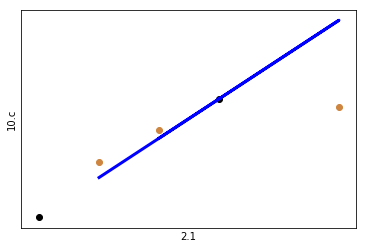

2.1 10.c
MAE: 0.46667
RMSE: 0.64807
R2: 0.000
--------------------------


2.1 17.8
MAE: 2.87719
RMSE: 2.97694
R2: 0.910
--------------------------




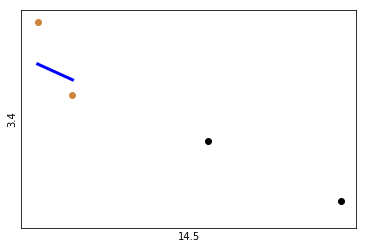

14.5 3.4
MAE: 0.02397
RMSE: 0.02645
R2: 0.248
--------------------------


14.5 8.1
MAE: 1.71030
RMSE: 1.71696
R2: 0.000
--------------------------




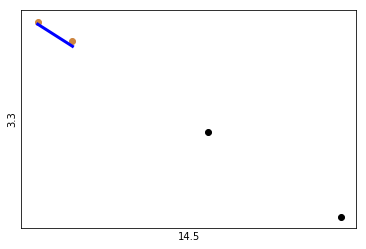

14.5 3.3
MAE: 0.05993
RMSE: 0.06310
R2: 0.823
--------------------------


14.5 3.1
MAE: 3.41138
RMSE: 4.09112
R2: 0.000
--------------------------


14.5 9.c
MAE: 8.47353
RMSE: 11.47952
R2: 0.000
--------------------------




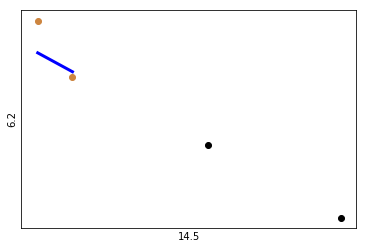

14.5 6.2
MAE: 0.92360
RMSE: 1.12779
R2: 0.346
--------------------------


14.5 6.1
MAE: 11.93819
RMSE: 12.47109
R2: 0.000
--------------------------




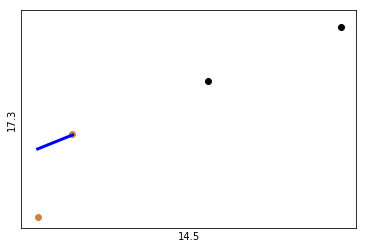

14.5 17.3
MAE: 0.07064
RMSE: 0.09869
R2: 0.000
--------------------------




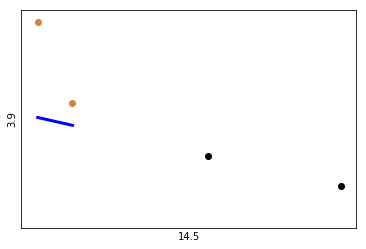

14.5 3.9
MAE: 0.02560
RMSE: 0.03008
R2: 0.000
--------------------------


14.5 8.2
MAE: 2.86036
RMSE: 3.29457
R2: 0.000
--------------------------


14.5 15.4
MAE: 2.64563
RMSE: 3.43601
R2: 0.337
--------------------------


14.5 16.a
MAE: 5.42128
RMSE: 7.85017
R2: 0.110
--------------------------




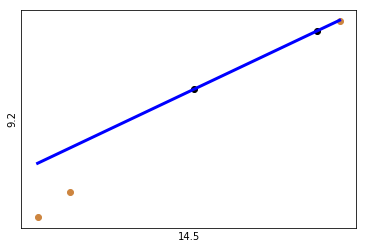

14.5 9.2
MAE: 0.16906
RMSE: 0.20615
R2: 0.789
--------------------------


14.5 15.1
MAE: 3.54594
RMSE: 4.97447
R2: 0.000
--------------------------


14.5 17.8
MAE: 2.68830
RMSE: 2.93169
R2: 0.594
--------------------------




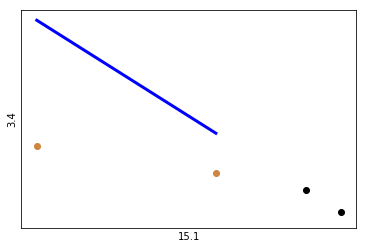

15.1 3.4
MAE: 0.18881
RMSE: 0.21271
R2: 0.000
--------------------------


15.1 14.4
MAE: 1.58937
RMSE: 1.95336
R2: 0.812
--------------------------




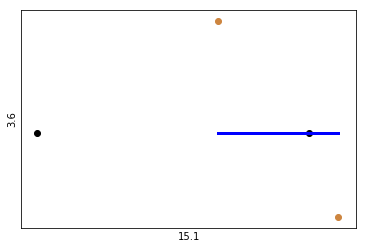

15.1 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


15.1 8.1
MAE: 1.40570
RMSE: 1.85821
R2: 0.000
--------------------------




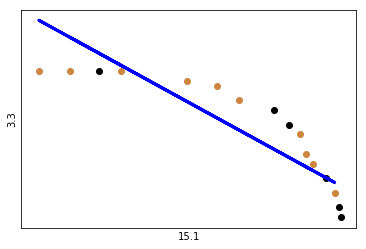

15.1 3.3
MAE: 0.47502
RMSE: 0.55247
R2: 0.604
--------------------------


15.1 3.1
MAE: 8.58846
RMSE: 9.96704
R2: 0.000
--------------------------


15.1 9.c
MAE: 6.61503
RMSE: 11.33131
R2: 0.368
--------------------------


15.1 4.2
MAE: 5.26783
RMSE: 7.54564
R2: 0.000
--------------------------




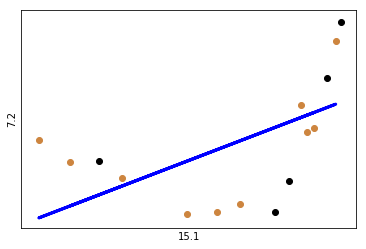

15.1 7.2
MAE: 0.31120
RMSE: 0.36246
R2: 0.122
--------------------------


15.1 6.2
MAE: 1.00101
RMSE: 1.08929
R2: 0.834
--------------------------


15.1 6.1
MAE: 1.02362
RMSE: 1.23812
R2: 0.951
--------------------------


15.1 9.5
MAE: 2.69291
RMSE: 2.93149
R2: 0.901
--------------------------




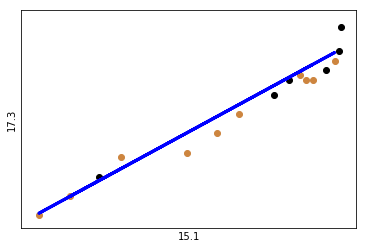

15.1 17.3
MAE: 0.02044
RMSE: 0.02399
R2: 0.948
--------------------------




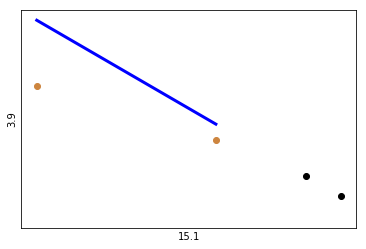

15.1 3.9
MAE: 0.02640
RMSE: 0.03082
R2: 0.000
--------------------------


15.1 8.2
MAE: 1.09364
RMSE: 1.35838
R2: 0.000
--------------------------


15.1 7.1
MAE: 9.49905
RMSE: 11.26651
R2: 0.000
--------------------------




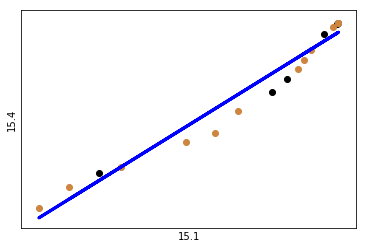

15.1 15.4
MAE: 0.57678
RMSE: 0.67727
R2: 0.963
--------------------------


15.1 16.a
MAE: 2.02000
RMSE: 2.24941
R2: 0.927
--------------------------




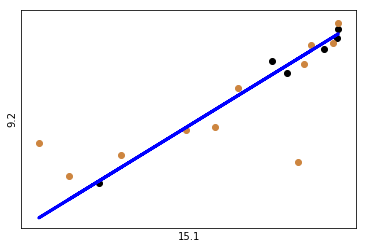

15.1 9.2
MAE: 0.20914
RMSE: 0.33691
R2: 0.400
--------------------------




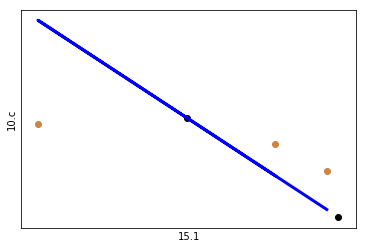

15.1 10.c
MAE: 0.87862
RMSE: 1.00705
R2: 0.000
--------------------------


15.1 17.8
MAE: 4.18598
RMSE: 4.62225
R2: 0.783
--------------------------




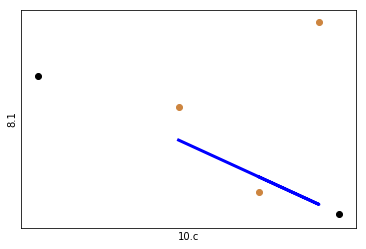

10.c 8.1
MAE: 0.24444
RMSE: 0.34181
R2: 0.000
--------------------------




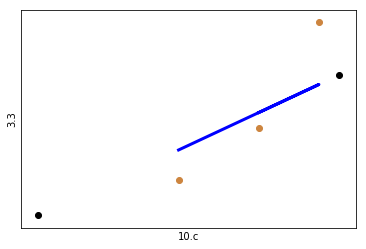

10.c 3.3
MAE: 0.20444
RMSE: 0.23267
R2: 0.613
--------------------------


10.c 9.c
MAE: 1.28444
RMSE: 1.36841
R2: 0.142
--------------------------


10.c 4.2
MAE: 1.32938
RMSE: 1.61348
R2: 0.000
--------------------------




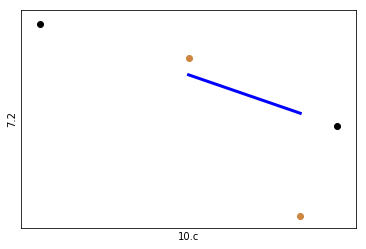

10.c 7.2
MAE: 0.24625
RMSE: 0.30283
R2: 0.132
--------------------------




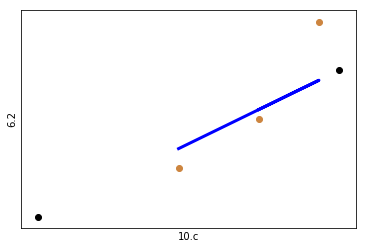

10.c 6.2
MAE: 0.44422
RMSE: 0.54828
R2: 0.653
--------------------------




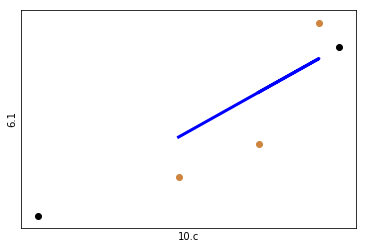

10.c 6.1
MAE: 0.24200
RMSE: 0.24497
R2: 0.580
--------------------------


10.c 9.5
MAE: 1.44263
RMSE: 1.71404
R2: 0.296
--------------------------




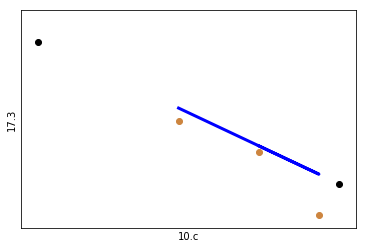

10.c 17.3
MAE: 0.01267
RMSE: 0.01587
R2: 0.595
--------------------------




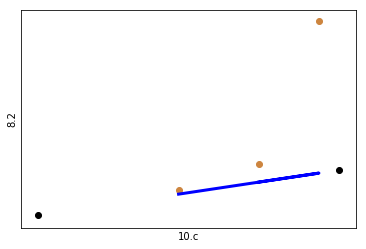

10.c 8.2
MAE: 0.29644
RMSE: 0.45092
R2: 0.000
--------------------------




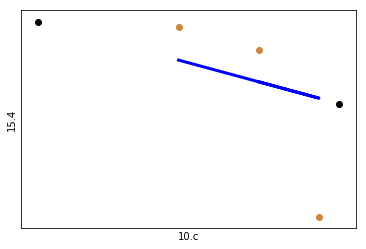

10.c 15.4
MAE: 0.46511
RMSE: 0.55810
R2: 0.245
--------------------------




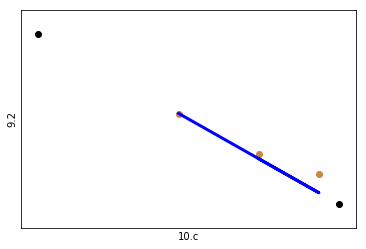

10.c 9.2
MAE: 0.00800
RMSE: 0.01112
R2: 0.801
--------------------------


10.c 17.8
MAE: 1.54333
RMSE: 2.20452
R2: 0.631
--------------------------




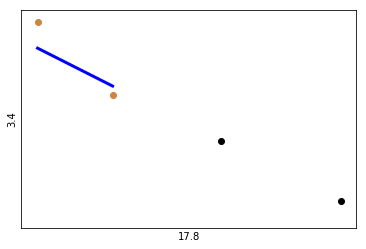

17.8 3.4
MAE: 0.01479
RMSE: 0.01645
R2: 0.709
--------------------------


17.8 14.4
MAE: 1.68705
RMSE: 2.32837
R2: 0.732
--------------------------




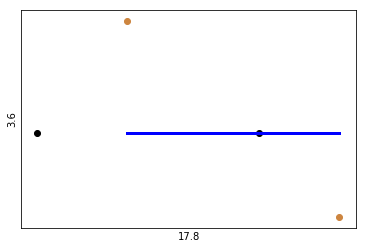

17.8 3.6
MAE: 0.07000
RMSE: 0.07071
R2: 0.000
--------------------------


17.8 8.1
MAE: 1.38139
RMSE: 1.82170
R2: 0.000
--------------------------




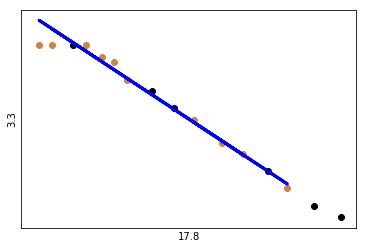

17.8 3.3
MAE: 0.12242
RMSE: 0.17892
R2: 0.958
--------------------------


17.8 3.1
MAE: 3.17172
RMSE: 3.60208
R2: 0.000
--------------------------


17.8 9.c
MAE: 7.15944
RMSE: 8.20399
R2: 0.669
--------------------------




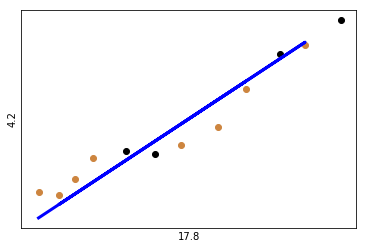

17.8 4.2
MAE: 0.96264
RMSE: 1.08860
R2: 0.854
--------------------------




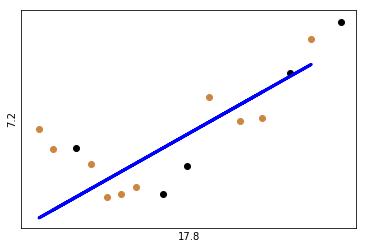

17.8 7.2
MAE: 0.27304
RMSE: 0.32809
R2: 0.281
--------------------------




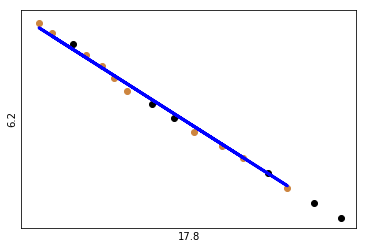

17.8 6.2
MAE: 0.16016
RMSE: 0.18882
R2: 0.995
--------------------------


17.8 6.1
MAE: 2.29345
RMSE: 2.61298
R2: 0.782
--------------------------


17.8 9.5
MAE: 1.05606
RMSE: 1.19479
R2: 0.984
--------------------------




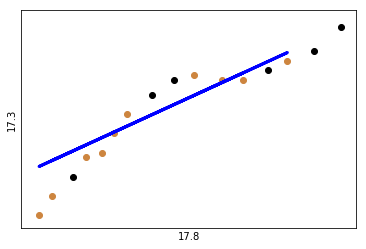

17.8 17.3
MAE: 0.03364
RMSE: 0.04484
R2: 0.818
--------------------------




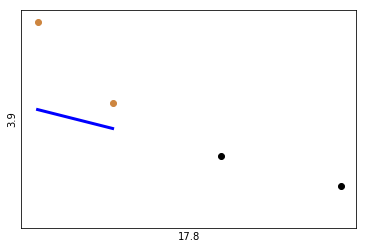

17.8 3.9
MAE: 0.02456
RMSE: 0.02799
R2: 0.000
--------------------------


17.8 8.2
MAE: 1.10264
RMSE: 1.38126
R2: 0.000
--------------------------


17.8 7.1
MAE: 1.10039
RMSE: 1.14654
R2: 0.392
--------------------------




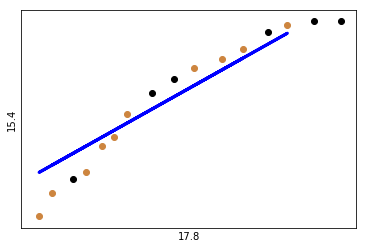

17.8 15.4
MAE: 0.87432
RMSE: 1.05987
R2: 0.895
--------------------------


17.8 16.a
MAE: 7.66216
RMSE: 9.16735
R2: 0.000
--------------------------




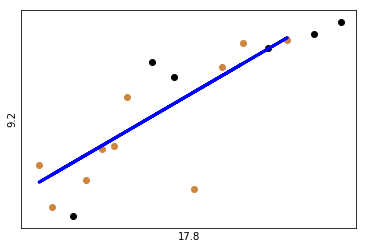

17.8 9.2
MAE: 0.16600
RMSE: 0.24296
R2: 0.620
--------------------------




In [30]:
keep =[]
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        if targety in notPercentTargets:
                            if 0<=mae<0.5: # 5 percent tolerance (converted to tonnes)
                                #print('MAE', targetx, targety, mae)
                                keep.append((final_t[targetx], final_t[targety]))

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                            
                            else: discardedPairs.extend([set([targetx, targety])])


                        else:
                            if 1 > mae > 0: # tolerate 1 percent error
                                keep.append((final_t[targetx], final_t[targety]))

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                                
                            else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('--------------------------')
                        print('\n')

#print(keep)

In [31]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  149


In [32]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['17.19', '14.4'], ['17.19', '8.1'], ['17.19', '9.c'], ['17.19', '4.2'], ['17.19', '6.2'], {'17.19', '9.4'}, ['9.4', '6.1'], ['9.4', '9.5'], ['9.4', '8.2'], ['9.4', '7.1'], ['9.4', '17.8'], ['3.4', '8.1'], ['3.4', '3.1'], ['12.2', '9.c'], ['14.4', '8.1'], ['12.2', '14.4'], ['12.2', '6.1'], ['12.2', '9.5'], ['12.2', '8.2'], ['12.2', '17.8'], ['3.6', '8.1'], ['3.6', '3.3'], ['8.1', '3.3'], ['8.1', '3.1'], ['12.2', '8.1'], ['3.3', '3.1'], ['9.c', '14.4'], ['9.c', '8.1'], ['9.c', '3.1'], ['9.c', '4.2'], ['9.c', '6.2'], ['9.4', '9.c'], ['4.2', '14.4'], ['4.2', '8.1'], ['9.4', '4.2'], ['7.2', '14.4'], ['7.2', '8.1'], ['7.2', '6.2'], ['6.2', '14.4'], ['6.2', '8.1'], ['6.2', '3.1'], ['9.4', '14.4'], ['9.4', '8.1'], ['17.19', '6.1'], ['17.19', '9.5'], ['17.19', '8.2'], ['17.19', '15.4'], ['17.19', '2.1'], ['17.19', '15.1'], ['17.19', '10.c'], ['17.19', '17.8'], ['6.1', '8.1'], ['6.1', '3.1'], ['6.1', '9.c'], ['6.1', '4.2'], ['8.4', '6.1'], ['8.4', '9.5'], ['8.4', '8.2'], ['8.4', '17.8'], ['9.5

### perhaps needed
what needs to be done before

#### what will happen next:

we have a temporal model with missing observations as NaNs, and want to infer them

In [33]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


In [34]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 29
N_mis: 115


## Define STAN model

In [35]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer)
    real y_mis2[N_mis];        // missing time-series data (to infer)
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood
}
"""

In [36]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

In [37]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

ValueError: Failed to parse Stan model 'anon_model_96c9744a7e4cd165c0b488a89db0b69c'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

variable "T" does not exist.
  error in 'unknown file name' at line 17, column 13
  -------------------------------------------------
    15:     vector<lower=0>[2] tau;
    16:     real<lower=0> sigma;       // observation noise
    17:     matrix[T,2] z;             // vector of latent states
                    ^
    18:     real y_mis1[N_mis];        // missing time-series data (to infer)
  -------------------------------------------------



In [38]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

NameError: name 'sm' is not defined

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"])
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))